# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

### First, import the library that we need

In [41]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from scipy import ndimage
from skimage.transform import resize
from skimage.data import imread
from skimage import color
import pickle

### Here I use a class called data to manage the dataset
* First, I load the train, val, test data by function `load_data()`
* Then check the number of the data and label
* normalize the grayscale the images by function `normal_grayscale()` (Here I use the skimage to do the image process)
* Augment training data by using function `expend_training_data()`
* I wirte a function called `next_batch()` to feed random minibatch to the model

In [42]:
class data(object):
    def __init__(self, training_file, validation_file, testing_file):
        self.train_x, self.train_y = self.load_data(training_file)
        self.val_x, self.val_y = self.load_data(validation_file)
        self.test_x, self.test_y = self.load_data(testing_file)
        # check the num of data and label
        self.check_data()

        self.normal_grayscale()

        self.img_shape = self.train_x[0].shape
        self.n_classes = np.max(self.train_y) + 1

        self.expend_training_data()

        self.n_train = self.train_x.shape[0]
        self.n_val = self.val_x.shape[0]
        self.n_test = self.test_x.shape[0]

    def check_data(self):
        assert (len(self.train_x) == len(self.train_y))
        assert (len(self.val_x) == len(self.val_y))
        assert (len(self.test_x) == len(self.test_y))

    def print_data_info(self):
        print("Number of training examples =", self.n_train)
        print("Number of validation examples =", self.n_val)
        print("Number of testing examples =", self.n_test)
        print("Image data shape =", self.img_shape)
        print("Number of classes =", self.n_classes)

    def load_data(self, path):
        with open(path, mode='rb') as f:
            tmp = pickle.load(f)
        return tmp['features'], tmp['labels']

    def normal_grayscale(self):
        self.train_x = (self.train_x - 128.) / 128.
        self.val_x = (self.val_x - 128.) / 128.
        self.test_x = (self.test_x - 128.) / 128.

        # convert rgb to gray scale
        self.train_x = color.rgb2gray(self.train_x)
        self.val_x = color.rgb2gray(self.val_x)
        self.test_x = color.rgb2gray(self.test_x)

    def next_batch(self, batch_size):
        """
        Return a total of `num` random samples and labels.
        """
        idx = np.arange(0, len(self.train_x))
        np.random.shuffle(idx)
        idx = idx[:batch_size]
        data_shuffle = [self.train_x[i] for i in idx]
        labels_shuffle = [self.train_y[i] for i in idx]

        return np.asarray(data_shuffle), np.asarray(labels_shuffle)


    def expend_training_data(self):
        """
        Augment training data
        """
        expanded_images = np.zeros([self.train_x.shape[0] * 5, self.img_shape[0], self.img_shape[1]])
        expanded_labels = np.zeros([self.train_x.shape[0] * 5])

        counter = 0
        for x, y in zip(self.train_x, self.train_y):

            # register original data
            expanded_images[counter, :, :] = x
            expanded_labels[counter] = y
            counter = counter + 1

            # get a value for the background
            # zero is the expected value, but median() is used to estimate background's value
            bg_value = np.median(x)  # this is regarded as background's value

            for i in range(4):
                # rotate the image with random degree
                angle = np.random.randint(-15, 15, 1)
                new_img = ndimage.rotate(x, angle, reshape=False, cval=bg_value)

                # shift the image with random distance
                shift = np.random.randint(-2, 2, 2)
                new_img_ = ndimage.shift(new_img, shift, cval=bg_value)

                # register new training data
                expanded_images[counter, :, :] = new_img_
                expanded_labels[counter] = y
                counter = counter + 1

        self.train_x = expanded_images
        self.train_y = expanded_labels

### Load data and print a basic summary of the dataset
The dataset is put into 

In [26]:
training_file = 'dataset/train.p'
validation_file = 'dataset/valid.p'
testing_file = 'dataset/test.p'

is_debug = True

data = data(training_file, validation_file, testing_file)
data.print_data_info()

Number of training examples = 173995
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### According to the info we know that there is 43 classes of sign. After data augmentation, the number of training sample become 173995. Next I write a plot function to show the images from the dataset

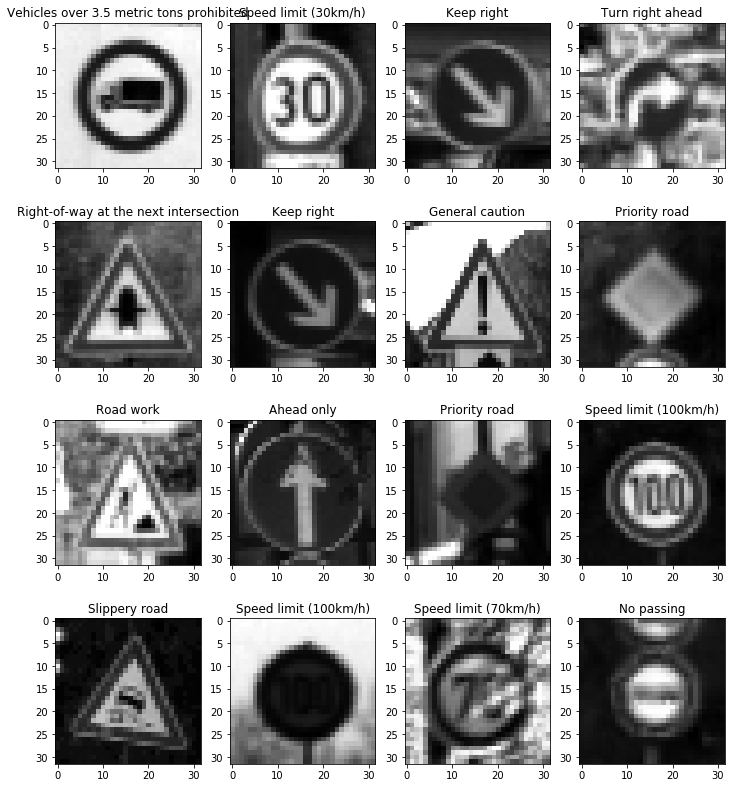

In [31]:
# use a dictionary to manage the key-label
label_dict = {}
with open('signnames.csv', 'r') as f:
    lines = f.readlines()
    for line in lines[1:]:
        tmp = line.strip('\n')
        tmp = tmp.split(',')
        label_dict[tmp[0]] = tmp[1]
    f.close()


def subplot_show(img_list, label_list, gray=False):
    """
    show 16 pictures
    the img_list must be a list with 16 images
    """
    plt.figure(figsize=(12, 14))
    for i in range(len(img_list)):
        plt.subplot(4, 4, i + 1)
        plt.title(label_dict[str(int(label_list[i]))])
        if gray is True:
            plt.imshow(img_list[i], cmap='gray')
        else:
            plt.imshow(img_list[i])
    plt.show()

# # the original images
# subplot_show(data.test_x[:4])

# image after normalization and convert to gray scale
if is_debug:
    subplot_show(data.test_x[:16], data.test_y[:16], gray=True)

### Show some images of training dataset, here we can see the result of data augmentation

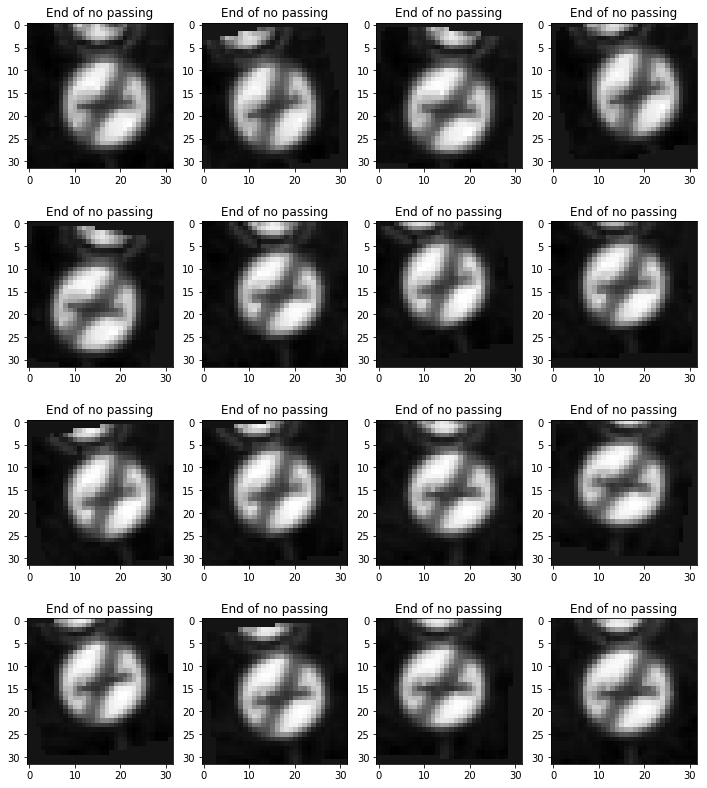

In [32]:
if is_debug:
    subplot_show(data.train_x[:16], data.train_y[:16], gray=True)

----

## Step 2: Design and Test a Model Architecture

### Model Architecture

### In this stage, I write a class called LeNet. I have not change the structure of the LeNet model. The kernal size, input size, output size, hidden neurons are all the same with lectures. I add the following code:
* First, I used the namespace and variable space to manage the paramenters instead of the dictionary
* I write some helper function like `conv2d()`, `maxpool2d()` and `fc_layer()`
* I write some information to summary so we can use **tensorboard** to visualize
* The model is saved to a checkpoint file by using saver
* Here I use the Adam Optimizer to train the model
* the learning rate is 0.001

In [33]:
class LeNet(object):
    def __init__(self, data, lr=0.001):

        self.x_placeholder = tf.placeholder(tf.float32, shape=[None, data.img_shape[0], data.img_shape[1]],
                                           name='input_x')
        tf.add_to_collection('x_placeholder', self.x_placeholder)
        self.y_placeholder = tf.placeholder(tf.int32, shape=[None], name='input_y')
        tf.add_to_collection('y_placeholder', self.y_placeholder)
        self.keep_p = tf.placeholder(tf.float32)

        input = tf.reshape(self.x_placeholder, (-1, data.img_shape[0], data.img_shape[1], 1))

        one_hot = tf.one_hot(self.y_placeholder, depth=data.n_classes)
        one_hot = tf.reshape(one_hot, (-1, data.n_classes))

        self.conv1 = self.conv2d(input, 'conv1', 5, 5, 1, 6)
        self.maxpool1 = self.maxpool2d(self.conv1, 'max_pool1')

        self.conv2 = self.conv2d(self.maxpool1, 'conv2', 5, 5, 6, 16)
        self.maxpool2 = self.maxpool2d(self.conv2, 'max_pool2')

        fc1 = tf.reshape(self.maxpool2, [-1, 5 * 5 * 16])
        fc1 = self.fc_layer(fc1, 'fc1', 5 * 5 * 16, 120, relu=True)
        # add dropout layer
        fc1_dropout = tf.nn.dropout(fc1, keep_prob=self.keep_p)

        fc2 = self.fc_layer(fc1_dropout, 'fc2', 120, 84, relu=True)
        fc2_dropout = tf.nn.dropout(fc2, keep_prob=self.keep_p)

        self.output = self.fc_layer(fc2_dropout, 'out', 84, data.n_classes, relu=False)

        with tf.name_scope('global_operation'):
            self.global_step = tf.Variable(0, trainable=False)
            
            softmax = tf.nn.softmax(self.output, name='softmax')
            self.top_k = tf.nn.top_k(softmax, k=5)

            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=one_hot, logits=self.output))
            tf.add_to_collection('loss', self.loss)
            tf.summary.scalar('loss', self.loss)

            correct_pred = tf.equal(tf.argmax(self.output, 1), tf.argmax(one_hot, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32)) * 100
            tf.add_to_collection('accuracy', self.accuracy)
            tf.summary.scalar('accuracy', self.accuracy)

        with tf.name_scope('train'):
            optimizer = tf.train.AdamOptimizer(learning_rate=lr)
            self.train_op = optimizer.minimize(self.loss)

        self.saver = tf.train.Saver()

        self.merge = tf.summary.merge_all()
        log_dir = 'tf_log_dir'
        if not os.path.exists(log_dir):
            os.mkdir(log_dir)
        self.summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

    def conv2d(self, x, name, filter_height, filter_width, num_input, num_output, strides=1, padding='VALID'):
        with tf.variable_scope(name):
            W = tf.get_variable('weight', [filter_height, filter_width, num_input, num_output],
                                tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.1))
            tf.summary.histogram(name+'weight', W)

            b = tf.get_variable('bias', [num_output], tf.float32, initializer=tf.zeros_initializer())
            tf.summary.histogram(name+'bias', b)

            x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
            x = tf.nn.bias_add(x, b)
            return tf.nn.relu(x)

    def maxpool2d(self, x, name, k=2, padding='VALID'):
        with tf.name_scope(name):
            x = tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding=padding)
            return x

    def fc_layer(self, x, name, num_input, num_output, relu=True):
        with tf.variable_scope(name):
            W = tf.get_variable('weight', [num_input, num_output], tf.float32,
                                initializer=tf.truncated_normal_initializer(stddev=0.1))
            tf.summary.histogram(name + 'weight', W)
            b = tf.get_variable('bias', [num_output], tf.float32,
                                initializer=tf.zeros_initializer())
            tf.summary.histogram(name + 'bias', b)
            x = tf.nn.xw_plus_b(x, W, b)
            if relu:
                x = tf.nn.relu(x)
                return x
            else:
                return x

### Train, Validate and Test the Model

### Training stage
* I train the model for 20 epoch
* The batch size I used is 128
* the model is saved to the 'model_save_dir'

In [34]:
model = LeNet(data)

# the training stage
num_epoch = 20
batch_size = 128
save_dir = 'model_save_dir'
num_step = int(np.round(data.n_train/batch_size))
is_training = True

if not os.path.exists(save_dir):
    os.mkdir(save_dir)
save_path = os.path.join(save_dir, 'convnet_model.ckpt')

### Start training in the session

In [35]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
if is_training:
    for epoch in range(num_epoch):
        for step in range(num_step):
            batch_x, batch_y = data.next_batch(batch_size)

            # define a feed dict to input minibatch
            feed_dict = {model.x_placeholder: batch_x, model.y_placeholder: batch_y, model.keep_p:0.5}

            sess.run(model.train_op, feed_dict=feed_dict)

        # eval stage
        val_loss, val_acc, merge, g_step = sess.run([model.loss, model.accuracy, model.merge, model.global_step],
                                                    feed_dict={model.x_placeholder:data.val_x,
                                                               model.y_placeholder:data.val_y,
                                                               model.keep_p:1.0})
        # add some training info to summary file
        model.summary_writer.add_summary(merge, global_step=epoch)

        print('validation loss at eopch %d: %f' % (epoch, val_loss))
        print('validation accuracy at eopch %d: %f' % (epoch, val_acc))

        model.saver.save(sess, save_path, global_step=epoch)

    # test stage
    print('Test accuracy:', sess.run(model.accuracy,
                                     feed_dict={model.x_placeholder: data.test_x, model.y_placeholder: data.test_y, 
                                                model.keep_p:1.0}))
else:
    # load the pre-trained model
    model.saver.restore(sess, save_path + '-19')

validation loss at eopch 0: 0.746463
validation accuracy at eopch 0: 77.777794
validation loss at eopch 1: 0.448613
validation accuracy at eopch 1: 85.895714
validation loss at eopch 2: 0.348203
validation accuracy at eopch 2: 88.594124
validation loss at eopch 3: 0.326196
validation accuracy at eopch 3: 90.657616
validation loss at eopch 4: 0.278119
validation accuracy at eopch 4: 92.244926
validation loss at eopch 5: 0.286083
validation accuracy at eopch 5: 92.380974
validation loss at eopch 6: 0.262423
validation accuracy at eopch 6: 93.514763
validation loss at eopch 7: 0.252784
validation accuracy at eopch 7: 93.990959
validation loss at eopch 8: 0.235189
validation accuracy at eopch 8: 93.832222
validation loss at eopch 9: 0.244061
validation accuracy at eopch 9: 94.512497
validation loss at eopch 10: 0.225475
validation accuracy at eopch 10: 94.784615
validation loss at eopch 11: 0.240320
validation accuracy at eopch 11: 95.170090
validation loss at eopch 12: 0.273208
validation

---

## Step 3: Test a Model on New Images

### Load and Output the Images

I find 6 images on the web and put them in the folder 'web_imgs'

Here I normalize a & grayscale the images. Then these images have been resize to (32, 32)

In [36]:
# read the images and labels
path_list = os.listdir('web_imgs')
imgs_list = []
imgs_arr = np.zeros([6, 32, 32])
label_arr = np.zeros([6])
for item in path_list:
    imgs_list.append(imread(os.path.join('web_imgs', item)))
for i, item in enumerate(imgs_list):
    item = (item - 128.) / 128.
    item = color.rgb2gray(item)
    imgs_arr[i, :, :] = resize(item, (32, 32))
for i, item in enumerate(path_list):
    item = item.split('.')[0]
    item = int(item)
    label_arr[i] = item

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: U

### Predict the Sign Type for Each Image & Analyze Performance

the predict accuracy of web images is: 100.0


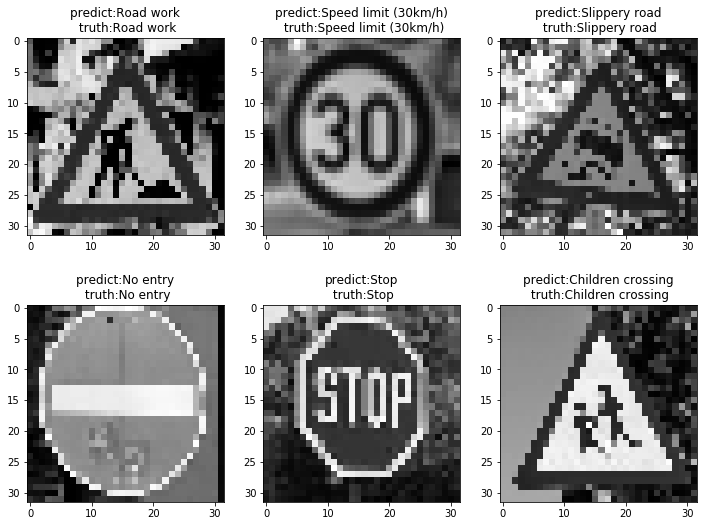

In [39]:
# run the pre-trained model to predict
output, acc, loss, top_k = sess.run([model.output, model.accuracy, model.loss, model.top_k], 
                                    feed_dict={model.x_placeholder:imgs_arr, model.y_placeholder:label_arr,
                                               model.keep_p:1.0})
print('the predict accuracy of web images is:', str(acc))

predict = np.argmax(output, 1)
plt.figure(figsize=(12, 9))
for i in range(len(imgs_arr)):
    plt.subplot(2, 3, i + 1)
    plt.title('predict:'+label_dict[str(int(predict[i]))]+'\n truth:'+label_dict[str(int(label_arr[i]))])
    plt.imshow(imgs_arr[i, :, :], cmap='gray')
plt.show()

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [40]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
print(top_k)

TopKV2(values=array([[  1.00000000e+00,   4.24368413e-13,   4.11477323e-14,
          3.04241156e-14,   3.15807552e-16],
       [  1.00000000e+00,   2.15572520e-08,   5.39909843e-18,
          1.33056148e-18,   9.34689587e-19],
       [  9.94475663e-01,   5.25100902e-03,   1.93915723e-04,
          4.63363212e-05,   1.72533328e-05],
       [  1.00000000e+00,   3.93703611e-11,   1.30396995e-11,
          2.24366410e-13,   5.24883041e-14],
       [  1.00000000e+00,   2.80333130e-13,   3.33084695e-14,
          3.45132447e-15,   1.62980455e-16],
       [  9.34252143e-01,   5.84988855e-02,   3.98163591e-03,
          1.62338756e-03,   1.24344206e-03]], dtype=float32), indices=array([[25, 11, 30, 18, 20],
       [ 1,  2,  7,  0,  4],
       [23, 20, 28, 19, 30],
       [17, 33, 14, 38, 34],
       [14, 38,  8,  4, 15],
       [28, 30, 25, 27, 20]], dtype=int32))


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [21]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")